In [1]:
from fit.datamodules.tomo_rec import MNIST_TRecFITDM
from fit.utils.tomo_utils import get_polar_rfft_coords_2D, get_polar_rfft_coords_sinogram
from fit.utils import denormalize, convert2DFT
from fit.modules import TRecTransformerModule

from matplotlib import pyplot as plt

import torch

import numpy as np

from pytorch_lightning import Trainer, seed_everything
from pytorch_lightning.callbacks import ModelCheckpoint

import wget
from os.path import exists

In [2]:
seed_everything(22122020)

Global seed set to 22122020


22122020

In [3]:
dm = MNIST_TRecFITDM(root_dir='./datamodules/data/', batch_size=128, num_angles=7)
# FIT: TRec + FBP vs FIT: TRec
with_fbp = False

dm.prepare_data()
dm.setup()

/tungstenfs/scratch/gmicro_share/_software/CondaEnvs/Linux/FDE_so/lib/python3.8/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1640811806235/work/aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [4]:
angles = dm.gt_ds.get_ray_trafo().geometry.angles
det_len = dm.gt_ds.get_ray_trafo().geometry.detector.shape[0]

In [5]:
img_shape = dm.gt_shape

In [6]:
proj_r, proj_phi, src_flatten = get_polar_rfft_coords_sinogram(angles=angles, 
                                                               det_len=det_len)
target_r, target_phi, dst_flatten, order = get_polar_rfft_coords_2D(img_shape=img_shape)

In [7]:
from fit import version

In [8]:
version.__version__

'0.2.4'

In [9]:
n_heads = 8
d_query = 32
model = TRecTransformerModule(d_model=n_heads * d_query, 
                              sinogram_coords=(proj_r, proj_phi),
                              target_coords=(target_r, target_phi),
                              src_flatten_coords=src_flatten, 
                              dst_flatten_coords=dst_flatten, 
                              dst_order=order,
                              angles=angles, 
                              img_shape=img_shape,
                              detector_len=det_len,
                              lr=0.001, 
                              t_0=100,
                              weight_decay=0.01, 
                              attention_type='linear', 
                              n_layers=4,
                              n_heads=n_heads, 
                              d_query=d_query, 
                              dropout=0.1, 
                              attention_dropout=0.1)

In [10]:
from pytorch_lightning.loggers import WandbLogger

wandb_logger = WandbLogger(project="fit", resume='allow')

from pytorch_lightning.callbacks.lr_monitor import LearningRateMonitor


In [13]:
trainer = Trainer(max_epochs=200,logger=wandb_logger,
                  gpus=1,
                  enable_checkpointing=True, 
                  callbacks=[ModelCheckpoint(
                                            dirpath='./debugging/reproduce',
                                            save_top_k=1,
                                            verbose=False,
                                            save_last=True,
                                            monitor='Train/avg_val_mse',
                                            mode='min'
                                        ),
                            LearningRateMonitor()],
                  deterministic=True)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [14]:
# Uncomment the next line if you want to train your own model. 
trainer.fit(model, datamodule=dm);

/tungstenfs/scratch/gmicro_share/_software/CondaEnvs/Linux/FDE_so/lib/python3.8/site-packages/pytorch_lightning/core/datamodule.py:469: LightningDeprecationWarning: DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/tungstenfs/scratch/gmicro_share/_software/CondaEnvs/Linux/FDE_so/lib/python3.8/site-packages/pytorch_lightning/trainer/optimizers.py:227: RuntimeWarning: Found unsupported keys in the optimizer configuration: {'interval'}
  rank_zero_warn(f"Found unsupported keys in the optimizer configuration: {set(extra_keys)}", RuntimeWarning)
wandb: Currently logged in as: tibuch (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.11 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade



  | Name | Type            | Params
-----------------------------------------
0 | trec | TRecTransformer | 7.4 M 
-----------------------------------------
7.4 M     Trainable params
0         Non-trainable params
7.4 M     Total params
29.500    Total estimated model params size (MB)
/tungstenfs/scratch/gmicro_share/_software/CondaEnvs/Linux/FDE_so/lib/python3.8/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:631: UserWarning: Checkpoint directory /tungstenfs/scratch/gmicro/buchtimo/gitrepos/FourierImageTransformer/examples/debugging/reproduce exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")


Validation sanity check: 0it [00:00, ?it/s]

/tungstenfs/scratch/gmicro_share/_software/CondaEnvs/Linux/FDE_so/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 48 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
Global seed set to 22122020
/tungstenfs/scratch/gmicro_share/_software/CondaEnvs/Linux/FDE_so/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 48 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

/tungstenfs/scratch/gmicro_share/_software/CondaEnvs/Linux/FDE_so/lib/python3.8/site-packages/fit/utils/RAdam.py:119: UserWarning: This overload of addcmul_ is deprecated:
	addcmul_(Number value, Tensor tensor1, Tensor tensor2)
Consider using one of the following signatures instead:
	addcmul_(Tensor tensor1, Tensor tensor2, *, Number value) (Triggered internally at  /opt/conda/conda-bld/pytorch_1640811806235/work/torch/csrc/utils/python_arg_parser.cpp:1050.)
  exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

/tungstenfs/scratch/gmicro_share/_software/CondaEnvs/Linux/FDE_so/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:688: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [17]:
wandb_logger.finalize(status=0)

In [10]:
if not exists('./models/trec_mnist/mnist_trec.ckpt'):
    wget.download('https://cloud.mpi-cbg.de/index.php/s/CWzpaYelI3lgkb8/download',
                  out='./models/trec_mnist/mnist_trec.ckpt')
    
if not exists('./models/trec_mnist/mnist_trec_fbp.ckpt'):
    wget.download('https://cloud.mpi-cbg.de/index.php/s/gHkhiuvqO90amdc/download',
                  out='./models/trec_mnist/mnist_trec_fbp.ckpt')

In [11]:
if with_fbp:
    path = './models/trec_mnist/mnist_trec_fbp.ckpt'
else:
    path = './models/trec_mnist/mnist_trec.ckpt'

In [15]:
model = TRecTransformerModule.load_from_checkpoint('debugging/epoch=198-step=85569.ckpt', 
                                               sinogram_coords=(proj_r, proj_phi),
                              target_coords=(target_r, target_phi),
                              src_flatten_coords=src_flatten, 
                              dst_flatten_coords=dst_flatten, 
                              dst_order=order, angles=angles, strict=False)

In [24]:
trainer = Trainer(max_epochs=10,
                  limit_train_batches=10,
                  limit_val_batches=5,
                  gpus=1,
                  deterministic=True)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [16]:
test_res = trainer.test(model, datamodule=dm)

/tungstenfs/scratch/gmicro_share/_software/CondaEnvs/Linux/FDE_so/lib/python3.8/site-packages/pytorch_lightning/core/datamodule.py:469: LightningDeprecationWarning: DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/tungstenfs/scratch/gmicro_share/_software/CondaEnvs/Linux/FDE_so/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 48 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

23.722003936767578
--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'Mean PSNR': 23.722003936767578, 'SEM PSNR': 0.02236746996641159}
--------------------------------------------------------------------------------


In [46]:
from fit.utils import denormalize_FC, denormalize, convert2DFT

In [47]:
def predict_img(model, x, fbp, y, amp_min, amp_max):
    model.eval()

    model.bin_factor = 1
#     model.register_buffer('mask', psf_rfft(model.bin_factor, pixel_res=model.hparams.img_shape).to(model.device))

    x_fc_, fbp_fc_, y_fc_ = model._bin_data(x, fbp, y)

    pred_fc = model.trec.forward(x_fc_, fbp_fc_, amp_min=amp_min, amp_max=amp_max,
                                          dst_flatten_coords=model.dst_flatten_order,
                                          img_shape=model.hparams.img_shape,
                                          attenuation=model.mask)

    tmp = denormalize_FC(pred_fc, amp_min=amp_min, amp_max=amp_max)
    pred_fc_ = torch.ones(x.shape[0], model.hparams.img_shape * (model.hparams.img_shape // 2 + 1), dtype=x.dtype,
                          device=x.device)
    pred_fc_[:, :tmp.shape[1]] = tmp

    dft_pred_fc = convert2DFT(x=pred_fc, amp_min=amp_min, amp_max=amp_max,
                              dst_flatten_order=model.dst_flatten_order, img_shape=model.hparams.img_shape)
    img_pred_before_conv = torch.roll(torch.fft.irfftn(dft_pred_fc, dim=[1, 2], s=2 * (model.hparams.img_shape,)),
                                      2 * (model.hparams.img_shape // 2,), (1, 2))
    return img_pred_before_conv

In [143]:
i = 0
for x_fc, fbp_fc, y_fc, y_real, (amp_min, amp_max) in dm.test_dataloader():
    if i >= 2:
        break
        
    i+=1

In [144]:
model.cpu();

In [145]:
pred_img = predict_img(model, x_fc, fbp_fc, y_fc, amp_min, amp_max).detach()

In [146]:
pred_img = denormalize(pred_img, model.trainer.datamodule.mean, model.trainer.datamodule.std) * model.circle

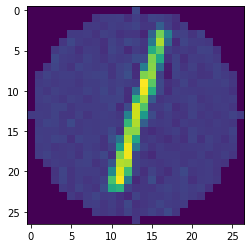

In [147]:
plt.imshow(pred_img[0])

In [148]:
gt = denormalize(y_real, model.trainer.datamodule.mean, model.trainer.datamodule.std) * model.circle

In [149]:
from fit.utils import PSNR

In [150]:
PSNR(gt[0], pred_img[0]*model.circle, gt.max() - gt.min())

tensor(31.0217)

In [151]:
PSNR(gt[0][model.circle], pred_img[0][model.circle], gt.max() - gt.min())

tensor(29.7779)

In [152]:
dft_fbp = convert2DFT(x=fbp_fc[:,model.dst_flatten_order], amp_min=amp_min, amp_max=amp_max,
                              dst_flatten_order=model.dst_flatten_order, img_shape=model.hparams.img_shape)
fbp_img = torch.roll(torch.fft.irfftn(model.mask * dft_fbp[0], s=2 * (model.hparams.img_shape,)),
                     2 * (model.hparams.img_shape // 2,), (0, 1))


fbp_img = (fbp_img - fbp_img.min())*255/(fbp_img.max() - fbp_img.min())
fbp_img = fbp_img * dm.__get_circle__()

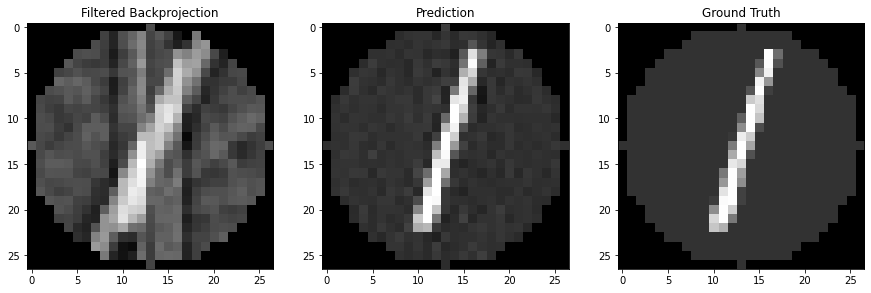

In [153]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.imshow(fbp_img, cmap='gray', vmin=gt[0].min(), vmax=gt[0].max())
plt.title('Filtered Backprojection');
plt.subplot(1,3,2)
plt.imshow(pred_img[0].detach(), cmap='gray', vmin=gt[0].min(), vmax=gt[0].max())
plt.title('Prediction');
plt.subplot(1,3,3)
plt.imshow(gt[0], cmap='gray', vmin=gt[0].min(), vmax=gt[0].max())
plt.title('Ground Truth');

In [129]:
fbp_psnrs = []
i = 0
for x_fc, fbp_fc, y_fc, y_real, (amp_min, amp_max) in dm.test_dataloader():
    dft_fbp = convert2DFT(x=fbp_fc[:,model.dst_flatten_order], amp_min=amp_min, amp_max=amp_max,
                              dst_flatten_order=model.dst_flatten_order, img_shape=model.hparams.img_shape)
    fbp_img = torch.roll(torch.fft.irfftn(model.mask * dft_fbp[0], s=2 * (model.hparams.img_shape,)),
                         2 * (model.hparams.img_shape // 2,), (0, 1))

    fbp_img = (fbp_img - fbp_img.min())*255/(fbp_img.max() - fbp_img.min())
    fbp_img = fbp_img * dm.__get_circle__()
    
    y_real = denormalize(y_real, dm.mean, dm.std) * dm.__get_circle__()
    fbp_psnrs.append(PSNR(y_real[0], fbp_img, y_real[0].max() - y_real[0].min()))

    i+=1
    if i >= 10000:
        break

In [130]:
np.mean(fbp_psnrs)

17.550404